<font size="3">**Importing the Data \& initial observations**</font>

In [1]:
import pandas as pd

csv_path = '/Users/sahandsetareh/MachineLearning/housing.csv'
housing = pd.read_csv(csv_path)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

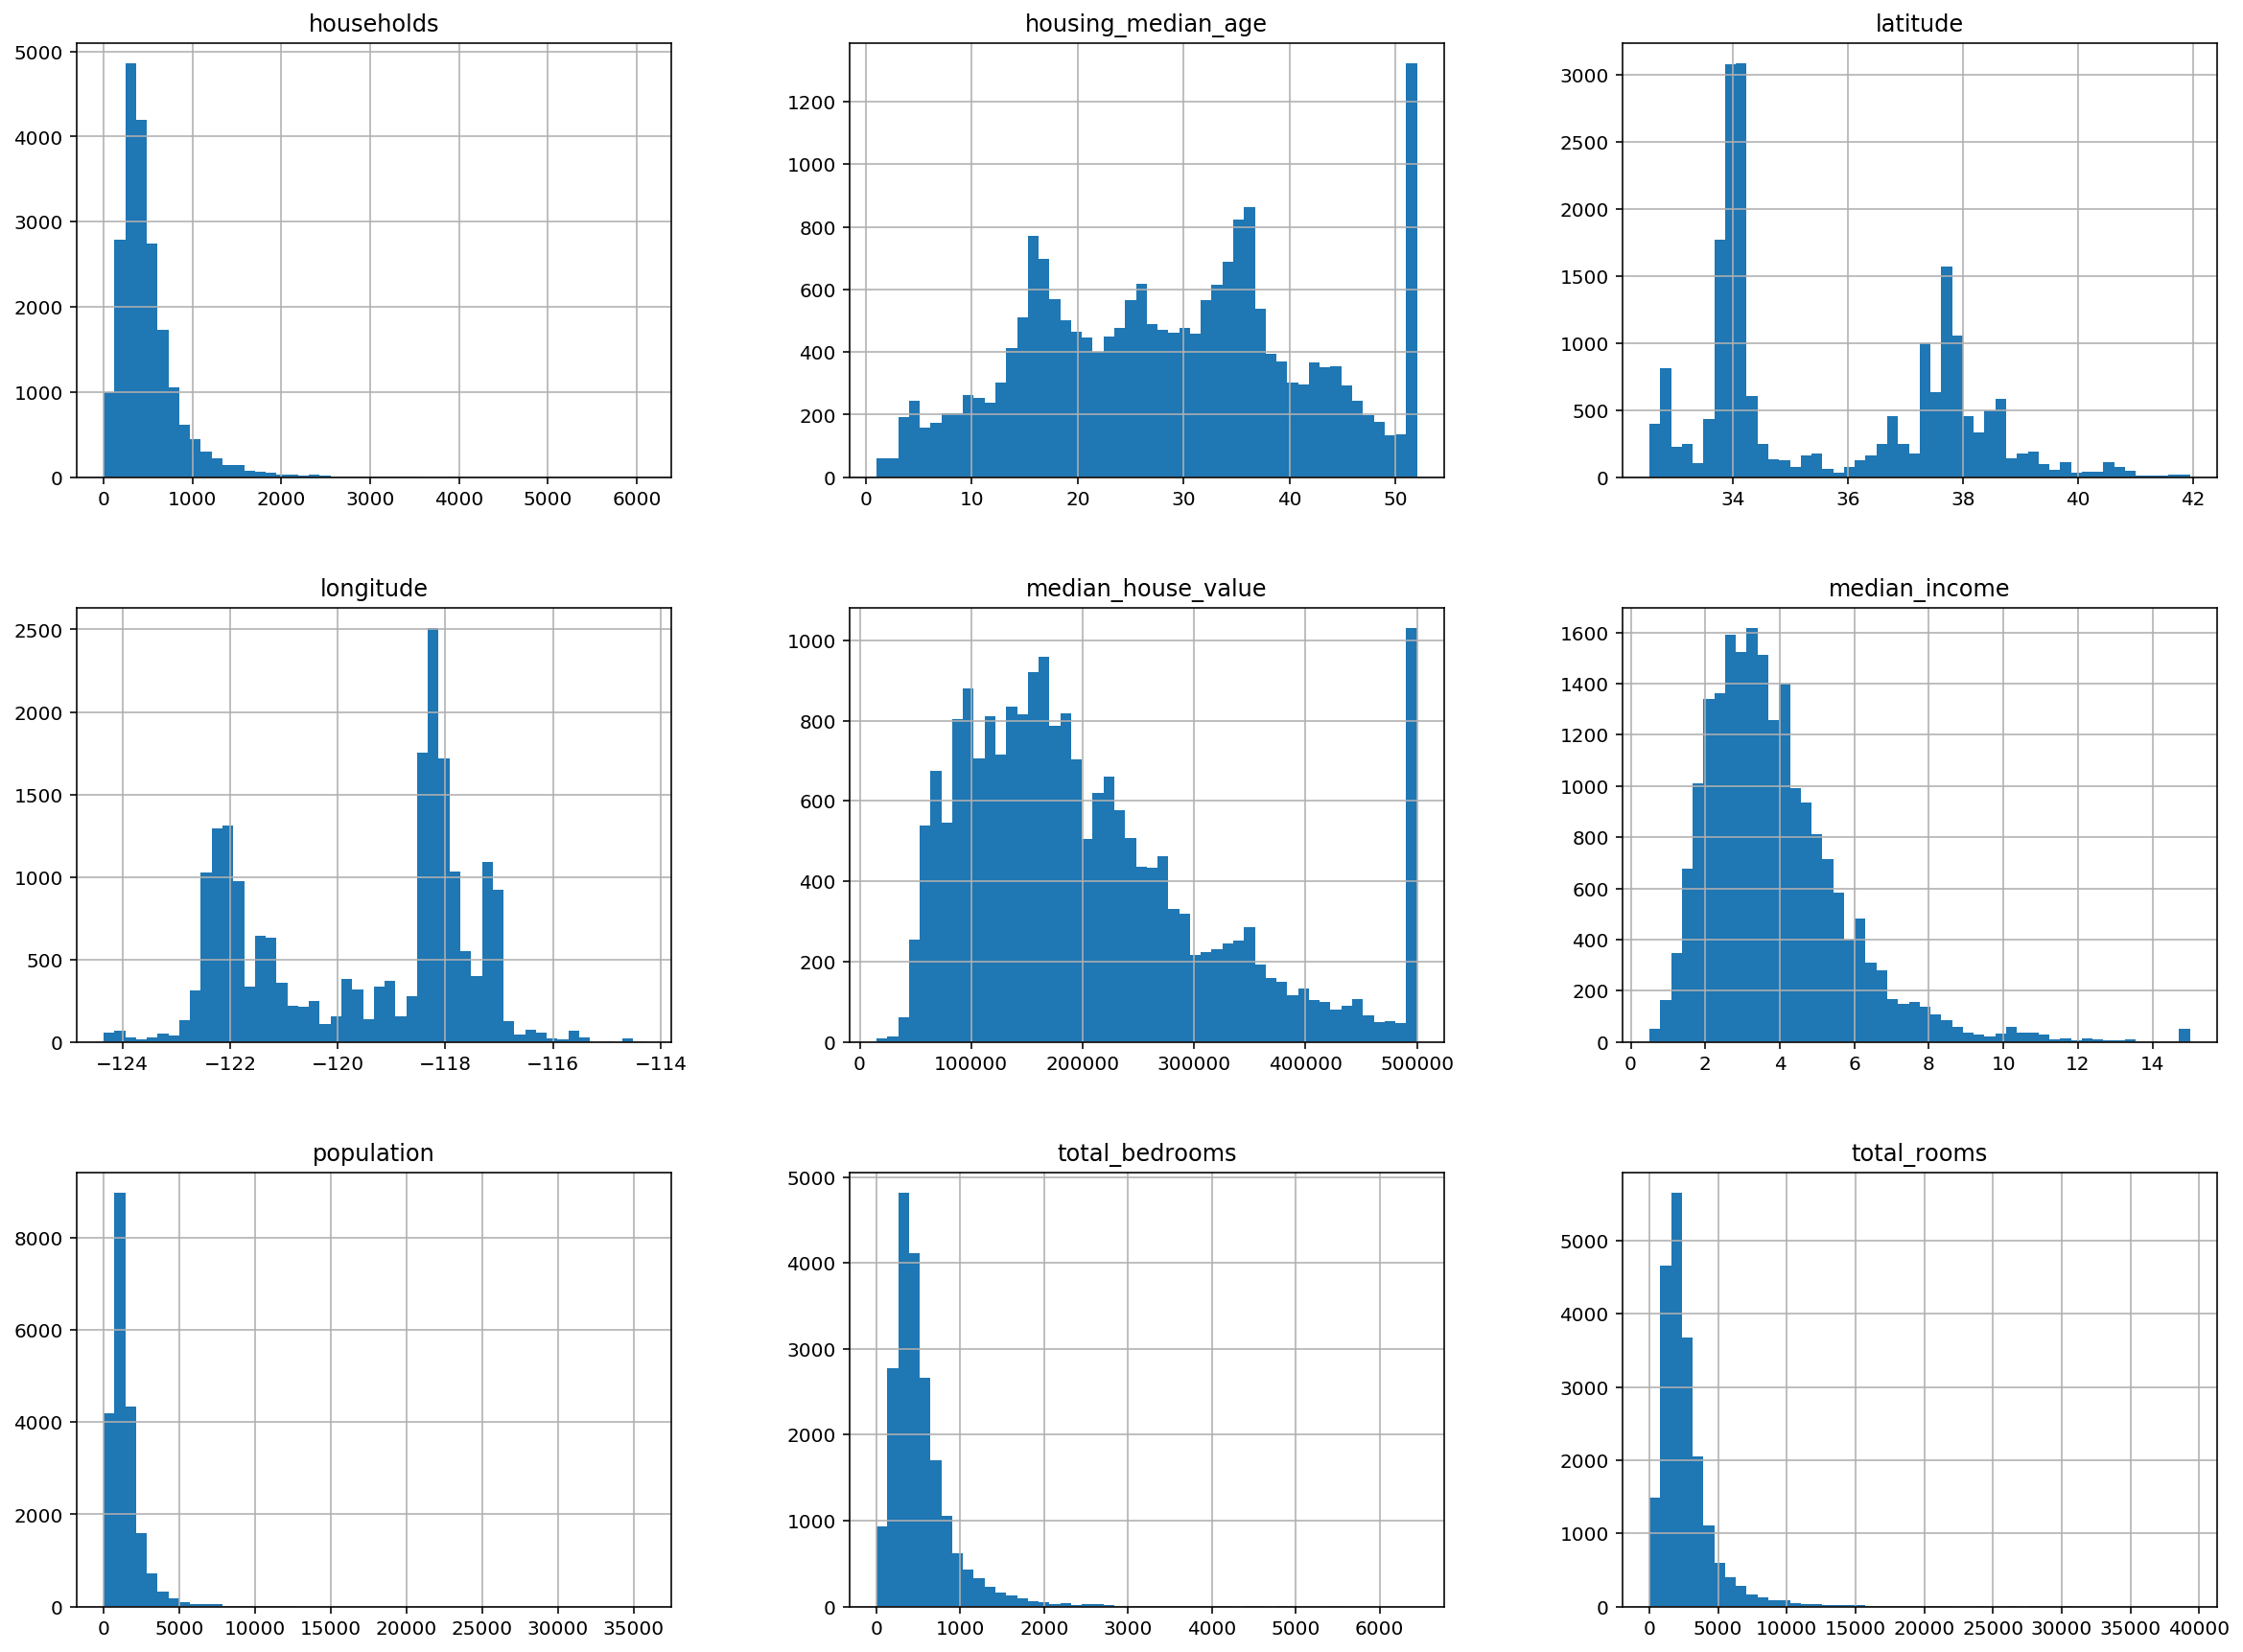

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

housing.hist(bins = 50, figsize = (20, 15))
plt.show()

<font size="3">**Creating a Test Set**</font>

In [4]:
# Creating a test set by picking 20% of the data points randomly
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [5]:
len(train_set)

16512

In [6]:
len(test_set)

4128

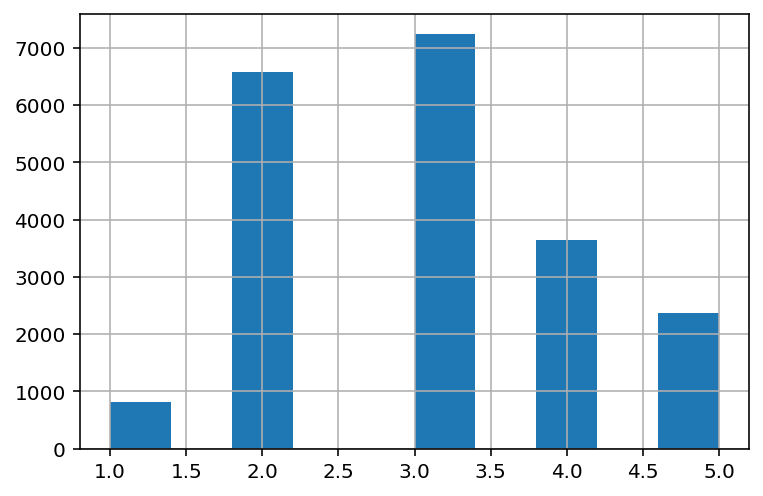

In [7]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], 
labels = [1, 2, 3, 4, 5])
housing["income_cat"].hist()
plt.show()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis =1, inplace = True)

In [11]:
housing = strat_train_set.copy()

<font size="3">**Visualizing Geographical Data**</font>

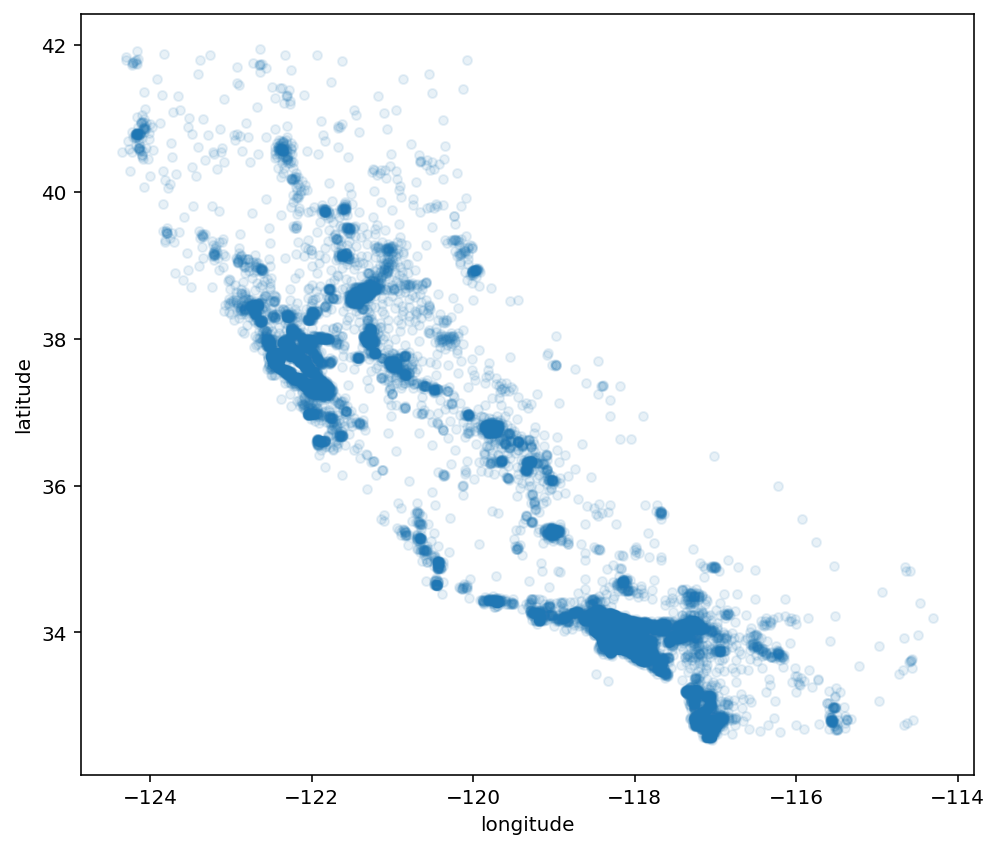

In [12]:
# Plotting Latitude vs Longitude
housing.plot(figsize = (8, 7), kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)
plt.show()

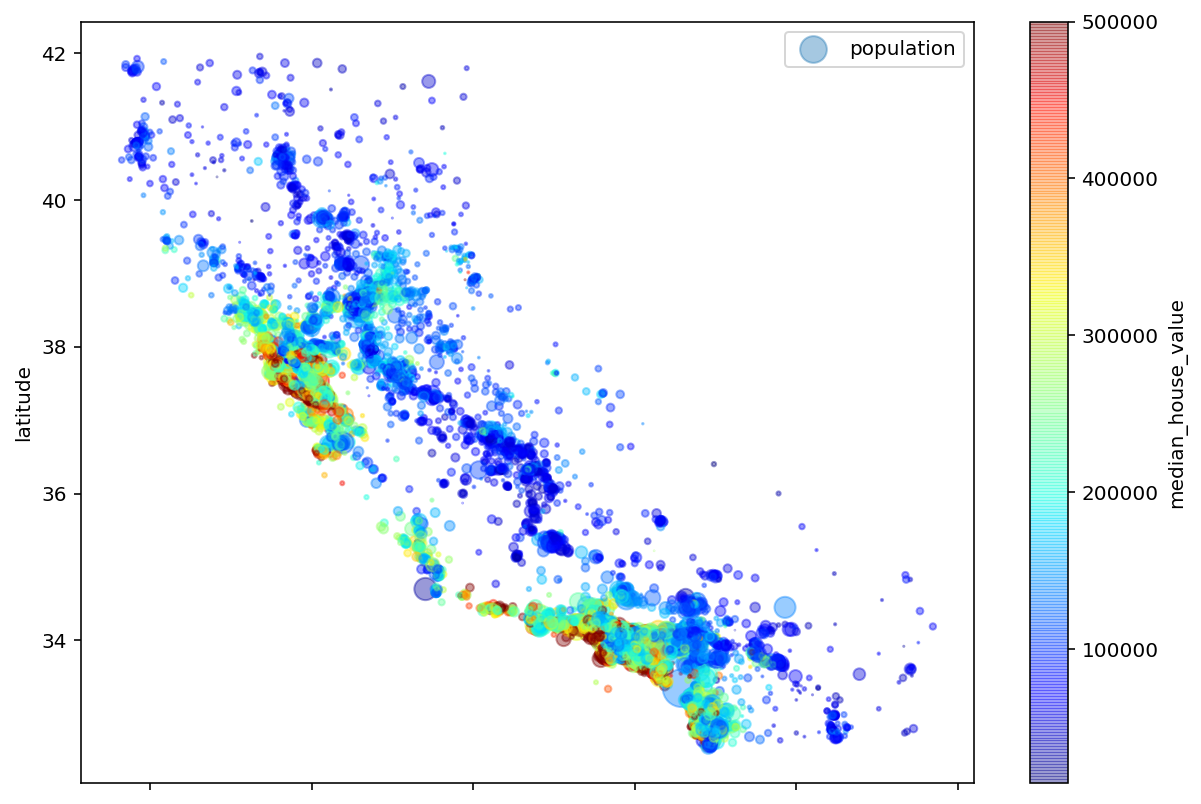

In [13]:
# The radius of each circle represents the district’s population (option s), and the color represents 
# the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue
# (low values) to red (high prices)

housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
s = housing["population"] / 100, label = "population", figsize = (10, 7),
c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()
plt.show()

We can observe that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density

<font size="3">**Looking for Correlations**</font>

In [14]:
# Standard Correlation Coefficient
corr_matrix = housing.corr()

In [15]:
# How each attribute correlates with median house value 
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation. When the coefficient is close to –1, it means that there is a strong negative correlation. We can see that median house value goes up when median income goes up (sign of a positive correlation), while the latitude and the median house value (small negative correlation), i.e., prices have a slight tendency to go down when you go north). 

Coefficients close to zero indicate that there is *no* linear correlation.

Another way we can check for correlation between attributes:

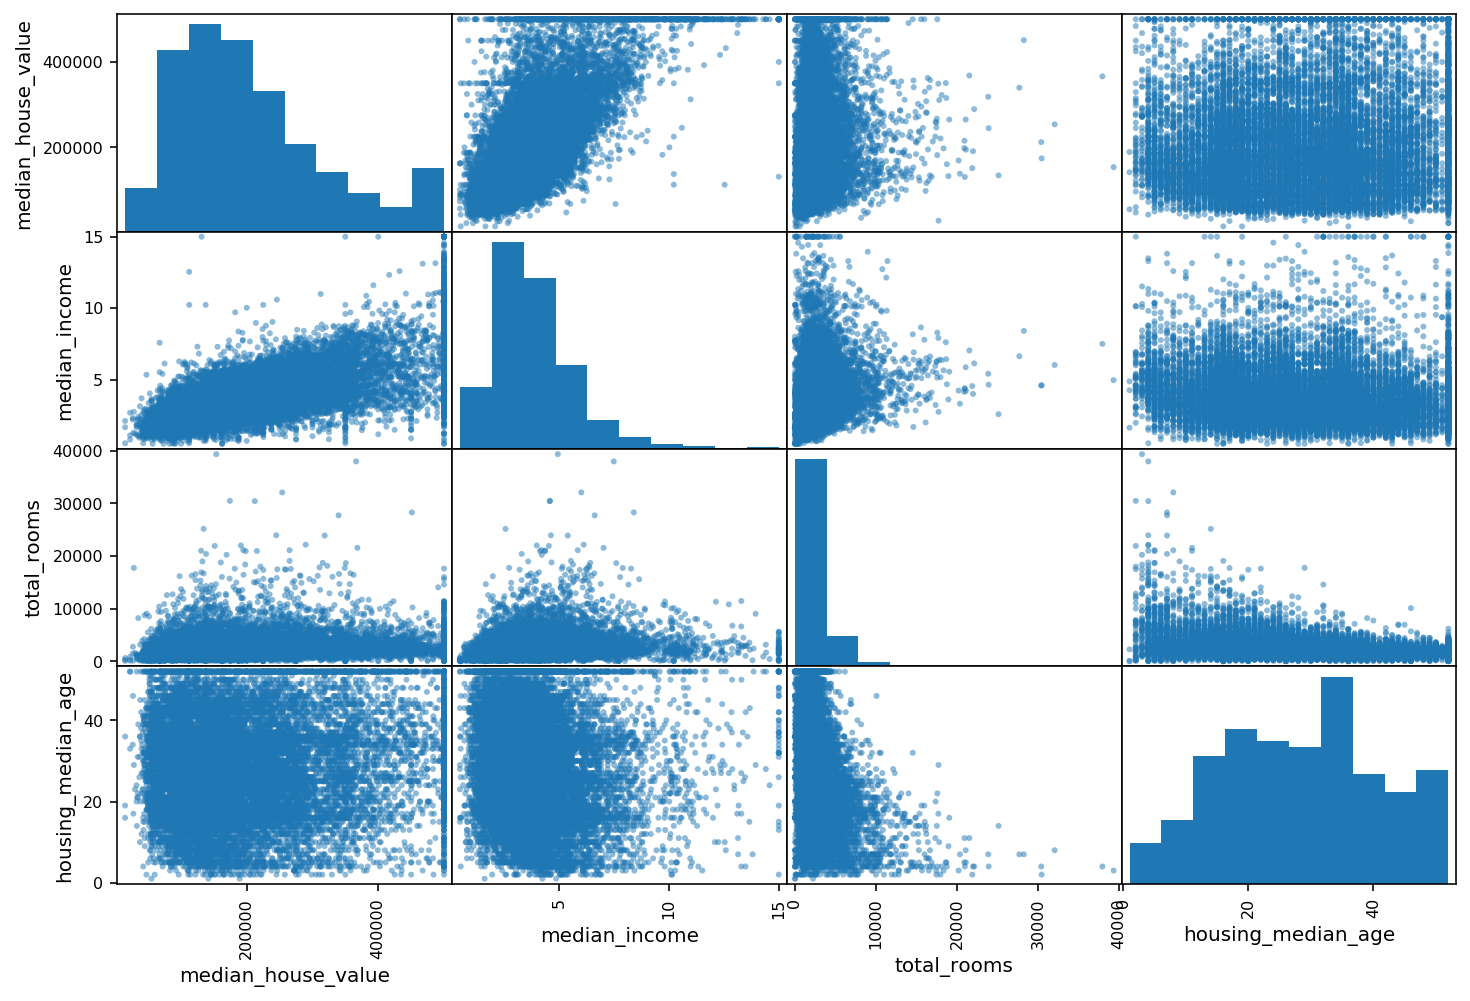

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

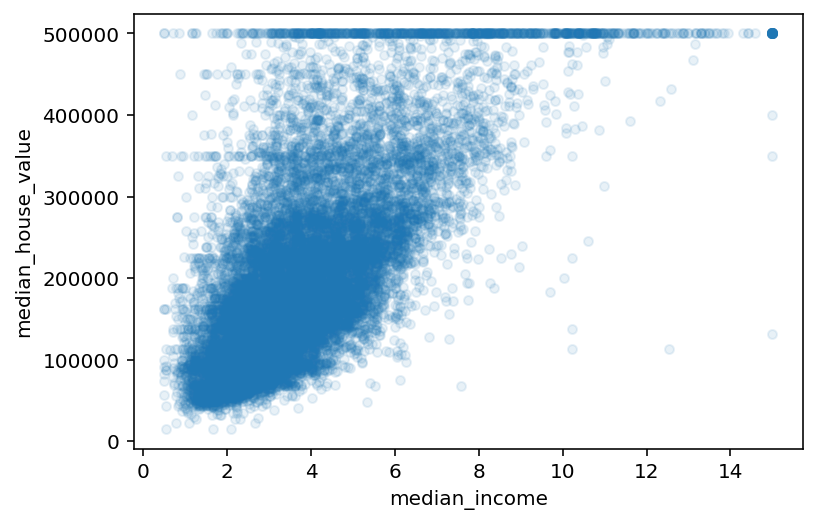

In [17]:
# The most promising attribute to predict the median house value is the median income
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)
plt.show()

We can observe a strong correlation between median inome and the median house value. However, there is the noticeable price cap in the data (\\$500,000), as well as other less visible lines at \\$450,000, and \\$350,000

<font size="3">**Experimenting with Attribute Combinations**</font>

Here we will try out various attribute combinations. 

For example, the total number of rooms in a district is not very useful if we don't know how many households there are. What we instead want to do is find the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: we probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [18]:
# Creating NEW attributes
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [19]:
# Looking at the correlation matrix again

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

We can see that the new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Houses with a lower bedroom/room ratio tend to be more expensive. The number of
rooms per household is also more informative than the total number of rooms in a district (the larger the houses, the more expensive they are).

<font size="3">**Cleaning \& Preparing the Data**</font>

In [20]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [22]:
housing_num.median().values
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

<font size="3">**Representing Text / Categorical Attributes Numerically**</font>

In [23]:
# ocean_proximity is a text attribute so we can't compute its median
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


We can use Scikit-Learn’s OrdinalEncoder class to convert these categories from text to numbers

In [24]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

In [25]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [26]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

The issue here is that these numbers are not necessarily representative of their similarity (i.e categories 0 and 4 are more similar than categories 0 and 1). We can resolve this by creating one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), etc. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [27]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self # nothing else to do
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy = "median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [30]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

<font size="3">**The ML Model: Selection and Training**</font>

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [33]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [34]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [35]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [37]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [39]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [68257.47100928 67584.83238365 71129.33666566 69456.41718537
 71213.20826349 75287.25282276 70650.12598056 70378.39233899
 76416.08764787 69286.63031876]
Mean: 70965.97546163903
Standard deviation: 2697.722702890079


In [40]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


In [41]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [42]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18788.652761128895

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
scoring = 'neg_mean_squared_error',
return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [44]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [45]:
# Obtaining the best estimator directly
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [46]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64799.61837978655 {'max_features': 2, 'n_estimators': 3}
55851.480346917444 {'max_features': 2, 'n_estimators': 10}
52878.823275644194 {'max_features': 2, 'n_estimators': 30}
60122.41005808134 {'max_features': 4, 'n_estimators': 3}
52960.57576109852 {'max_features': 4, 'n_estimators': 10}
50763.36582767965 {'max_features': 4, 'n_estimators': 30}
59776.871067102235 {'max_features': 6, 'n_estimators': 3}
51960.56027561402 {'max_features': 6, 'n_estimators': 10}
50120.045337244985 {'max_features': 6, 'n_estimators': 30}
58965.31735847833 {'max_features': 8, 'n_estimators': 3}
52262.282733453874 {'max_features': 8, 'n_estimators': 10}
49966.37497074877 {'max_features': 8, 'n_estimators': 30}
61664.651306360975 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54394.88257920587 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60005.99249233064 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52872.33546591587 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [47]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.81992884e-02, 6.95240612e-02, 4.22866659e-02, 1.67298464e-02,
       1.41206541e-02, 1.55964829e-02, 1.43728665e-02, 3.97204171e-01,
       3.60240644e-02, 1.16169195e-01, 5.92322318e-02, 4.51387687e-03,
       1.38879899e-01, 3.64955738e-05, 2.78650851e-03, 4.32369301e-03])

In [48]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.39720417099758365, 'median_income'),
 (0.13887989864440312, 'INLAND'),
 (0.11616919468270144, 'pop_per_hhold'),
 (0.0695240612164494, 'latitude'),
 (0.06819928842262353, 'longitude'),
 (0.059232231805601096, 'bedrooms_per_room'),
 (0.04228666592575825, 'housing_median_age'),
 (0.0360240644230877, 'rooms_per_hhold'),
 (0.016729846411884297, 'total_rooms'),
 (0.015596482922974648, 'population'),
 (0.014372866471792435, 'households'),
 (0.014120654101199242, 'total_bedrooms'),
 (0.004513876872665626, '<1H OCEAN'),
 (0.004323693014275761, 'NEAR OCEAN'),
 (0.0027865085131917474, 'NEAR BAY'),
 (3.649557380812618e-05, 'ISLAND')]

In [49]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2

In [50]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
    loc = squared_errors.mean(),
    scale = stats.sem(squared_errors)))

array([46325.19017479, 50238.13360333])